In [20]:
#Install Java Development kit for Spark
!apt-get install openjdk-8-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u265-b01-0ubuntu2~18.04).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [21]:
import os
#Set the JAVA_HOME env variable
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

In [22]:
#Current working directory
!pwd

/content


In [23]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [24]:
#Install PySpark with latest version
!pip install pyspark==3.0.0

In [25]:
#mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#Create object of spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-pipeline').getOrCreate()

In [27]:
#Read the csv file
df=spark.read.csv('/content/drive/My Drive/Colab Notebooks/Spark ML/bank.csv',inferSchema=True,header=True)

In [28]:
df.show(3)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
only showing top 3 rows



In [29]:
#Drop unwanted columns
df = df.drop(*['contact', 'day', 'month','default'])
df.columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [30]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [32]:
cols = df.columns
cols

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [33]:
#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string') ]
categoricalColumns

['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'deposit']

In [34]:
#create a list of the columns that are string typed
numericColumns = [item[0] for item in df.dtypes if item[1].startswith('int') ]
numericColumns

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

In [35]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [36]:
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [37]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [38]:
df.show(5)

+-----+--------------------+---+----------+-------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+
|label|            features|age|       job|marital|education|balance|housing|loan|duration|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+----------+-------+---------+-------+-------+----+--------+--------+-----+--------+--------+-------+
|  1.0|(28,[3,11,13,17,1...| 59|    admin.|married|secondary|   2343|    yes|  no|    1042|       1|   -1|       0| unknown|    yes|
|  1.0|(28,[3,11,13,16,1...| 56|    admin.|married|secondary|     45|     no|  no|    1467|       1|   -1|       0| unknown|    yes|
|  1.0|(28,[2,11,13,17,1...| 41|technician|married|secondary|   1270|    yes|  no|    1389|       1|   -1|       0| unknown|    yes|
|  1.0|(28,[4,11,13,17,1...| 55|  services|married|secondary|   2476|    yes|  no|     579|       1|   -1|       0| unknown|    yes|
|  1.0|(28,[3,11,14,16,1...| 54|    admin.|married| tertiary|    184|

In [39]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [40]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_df)

In [46]:
lr_summary=lrModel.summary

In [47]:
#Overall accuracy of the classification model
lr_summary.accuracy

1.0

In [48]:
#Area under ROC
lr_summary.areaUnderROC

0.999962256621913

In [49]:
#Precision of both classes
print(lr_summary.precisionByLabel)

[1.0, 1.0]


In [50]:
#Recall of both classes
print(lr_summary.recallByLabel)

[1.0, 1.0]


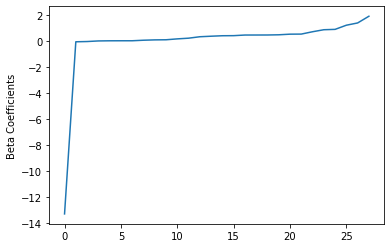

In [41]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

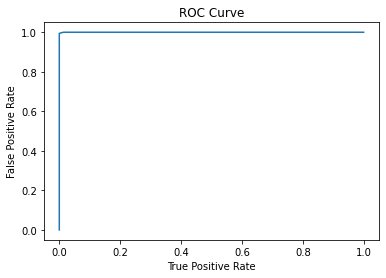

Training set areaUnderROC: 0.999962256621913


In [42]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

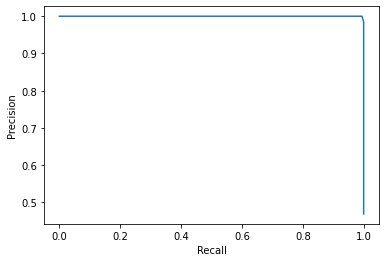

In [43]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [45]:
predictions = lrModel.transform(test_df)
predictions.select('label','rawPrediction','probability','prediction').show(10)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[7.76225657222473...|[0.99957468563370...|       0.0|
|  0.0|[6.90470259902823...|[0.99899794777172...|       0.0|
|  0.0|[7.34324962638215...|[0.99935347349439...|       0.0|
|  0.0|[6.76702106905225...|[0.99885020489917...|       0.0|
|  0.0|[5.15492178925034...|[0.99426218115267...|       0.0|
|  0.0|[6.86966387689437...|[0.99896225186051...|       0.0|
|  0.0|[6.84902127692915...|[0.99894063034000...|       0.0|
|  0.0|[7.04100709114993...|[0.99912552071622...|       0.0|
|  0.0|[6.92578514214332...|[0.99901883193390...|       0.0|
|  0.0|[6.69497738330229...|[0.99876441869652...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 10 rows

